In [51]:
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [53]:
# Set seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


In [55]:
# Load the ORL dataset
data = load_orl()
train, test = data["train"], data["test"]
print(f"Train set: {len(train)} samples")
print(f"Test set: {len(test)} samples")


Train set: 360 samples
Test set: 40 samples


In [57]:
# Set device for training
device = torch.device("mps" if torch.backends.mps.is_available() else 
                     ("cuda" if torch.cuda.is_available() else "cpu"))
print(f"Using device: {device}")

Using device: cpu


In [59]:

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  
        self.bn1 = nn.BatchNorm2d(16)
        
        # Second convolutional layer
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  
        self.bn2 = nn.BatchNorm2d(32)
        
        # Third convolutional layer
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  
        self.bn3 = nn.BatchNorm2d(64)
        
        # Calculate flattened feature size: 64 * 14 * 11 = 19712
        self.fc1 = nn.Linear(64 * 14 * 11, 256) 
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 40)  # 40 classes (people)

    def forward(self, x):
        # Apply convolutions with ReLU activations and max pooling
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)  # 112x92 -> 56x46
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)  # 56x46 -> 28x23
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)  # 28x23 -> 14x11
        
        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)
        
        # Apply fully connected layers with ReLU and dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [61]:
# Simple data augmentation function
def augment_image(img):
    """Apply simple data augmentation to a single image tensor"""
    # Add small random noise
    noise = torch.randn_like(img) * 0.02
    img = torch.clamp(img + noise, 0, 1)
    
    return img

In [63]:
def prepare_data(raw_data, batch_size=16, shuffle=True, augment=False):
   
    # Extract images and labels
    images = []
    labels = []
    
    for item in raw_data:
        # Get image and take only the R channel 
        img = item['image'][:, :, 0]  
        
        # Add channel dimension for CNN and normalize to [0, 1]
        img = np.expand_dims(img, axis=0).astype(np.float32) / 255.0
        
        # Add to lists
        images.append(img)
        labels.append(item['label'] - 1)  # Convert 1-40 labels to 0-39 for PyTorch
        
        # Apply simple data augmentation for training
        if augment:
            # Create an augmented version for each training image
            img_tensor = torch.from_numpy(img)
            aug_img = augment_image(img_tensor).numpy()
            images.append(aug_img)
            labels.append(item['label'] - 1)  # Same label for augmented image
    
    # Convert to numpy arrays then to PyTorch tensors
    tensor_images = torch.from_numpy(np.array(images))
    tensor_labels = torch.from_numpy(np.array(labels, dtype=np.int64))
    
    # Create dataset and dataloader
    dataset = TensorDataset(tensor_images, tensor_labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    

    return dataloader

In [65]:
def train(model, train_loader, criterion, optimizer, num_epochs=50):
   
    model.train()  # Set model to training mode
    epoch_losses = []
    loss_history = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        epoch_total_loss = 0.0
        batch_count = 0
        
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            # Move tensors to the configured device
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Track losses
            batch_loss = loss.item()
            running_loss += batch_loss
            epoch_total_loss += batch_loss
            loss_history.append(batch_loss)
            batch_count += 1
            
            # Print loss every 5 batches
            if (batch_idx + 1) % 5 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {running_loss/5:.4f}")
                running_loss = 0.0  # Reset running loss
        
        # Calculate and store average loss for this epoch
        avg_epoch_loss = epoch_total_loss / batch_count
        epoch_losses.append(avg_epoch_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_epoch_loss:.4f}")
        
        
    
    print("Finished Training")
    return epoch_losses, loss_history


In [67]:
def evaluate(model, test_loader):
   
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    # No need to track gradients for evaluation
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Get predictions
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            # Update statistics
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Store for detailed analysis
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate accuracy
    accuracy = 100 * correct / total
    print(f"Accuracy on test set: {accuracy:.2f}%")
    
    # Generate and print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))
    
    
    return accuracy, all_preds, all_labels



Starting training...
Epoch [1/40], Batch [5/45], Loss: 6.0344
Epoch [1/40], Batch [10/45], Loss: 4.5747
Epoch [1/40], Batch [15/45], Loss: 3.5121
Epoch [1/40], Batch [20/45], Loss: 3.3261
Epoch [1/40], Batch [25/45], Loss: 2.9892
Epoch [1/40], Batch [30/45], Loss: 2.9287
Epoch [1/40], Batch [35/45], Loss: 2.9406
Epoch [1/40], Batch [40/45], Loss: 2.5222
Epoch [1/40], Batch [45/45], Loss: 2.3587
Epoch [1/40], Average Loss: 3.4652
Epoch [2/40], Batch [5/45], Loss: 2.0544
Epoch [2/40], Batch [10/45], Loss: 2.0153
Epoch [2/40], Batch [15/45], Loss: 1.7749
Epoch [2/40], Batch [20/45], Loss: 1.7813
Epoch [2/40], Batch [25/45], Loss: 1.6732
Epoch [2/40], Batch [30/45], Loss: 1.5857
Epoch [2/40], Batch [35/45], Loss: 1.4644
Epoch [2/40], Batch [40/45], Loss: 1.4599
Epoch [2/40], Batch [45/45], Loss: 1.2078
Epoch [2/40], Average Loss: 1.6685
Epoch [3/40], Batch [5/45], Loss: 1.0096
Epoch [3/40], Batch [10/45], Loss: 0.8249
Epoch [3/40], Batch [15/45], Loss: 1.0067
Epoch [3/40], Batch [20/45], 

/Users/reetibandyopadhyay/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reetibandyopadhyay/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reetibandyopadhyay/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

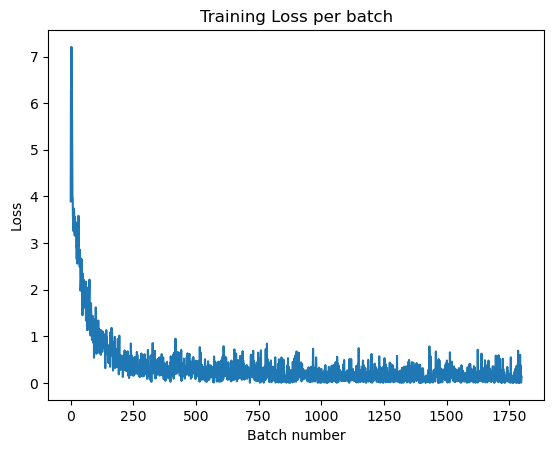

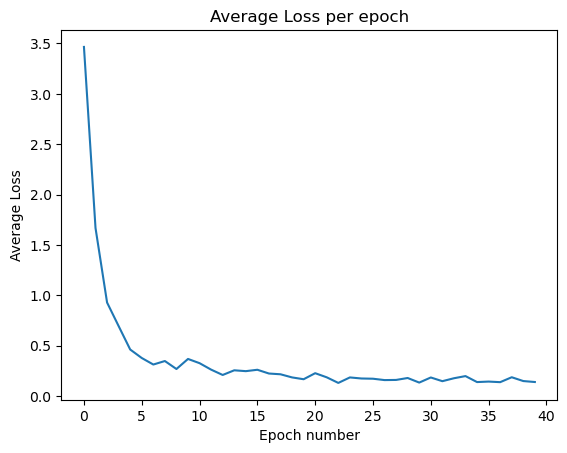

In [69]:
# Main execution
if __name__ == "__main__":
    # Compute class weights for balanced training
    train_labels = [instance['label'] for instance in data['train']]
    label_counts = Counter(train_labels)
    num_classes = 40  # 40 people
    weights = [1.0 / label_counts[i] for i in range(1, num_classes + 1)]
    class_weights = torch.tensor(weights, dtype=torch.float32).to(device)
    
    # Prepare data loaders (with augmentation for training)
    train_loader = prepare_data(data['train'], batch_size=16, augment=True)
    test_loader = prepare_data(data['test'], batch_size=8, shuffle=False)
    
    # Initialize the improved model
    model = CNN().to(device)
    
    # Use CrossEntropyLoss with class weights
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    # Use Adam optimizer with slight learning rate increase and weight decay
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    
    # Train the model
    print("\nStarting training...")
    epoch_losses, loss_history = train(model, train_loader, criterion, optimizer, num_epochs=40)
    
   
   
    # Evaluate the model
    print("\nStarting evaluation...")
    accuracy, predictions, true_labels = evaluate(model, test_loader)

    plt.figure()
    plt.plot(loss_history)
    plt.xlabel('Batch number')
    plt.ylabel('Loss')
    plt.title('Training Loss per batch')
    plt.show()

    plt.figure()
    plt.plot(epoch_losses)
    plt.xlabel('Epoch number')
    plt.ylabel('Average Loss')
    plt.title('Average Loss per epoch')
    plt.show()